[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PyPartMC/blob/main/examples/additive_coag_comparison.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyPartMC/blob/main/examples/additive_coag_comparison.ipynb)    
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyPartMC.git/main?urlpath=lab/tree/examples/additive_coag_comparison.ipynb)

In [1]:
# This file is a part of PyPartMC licensed under the GNU General Public License v3
# Copyright (C) 2023 University of Illinois Urbana-Champaign
# Authors:
#  - https://github.com/compdyn/partmc/graphs/contributors
#  - https://github.com/open-atmos/PyPartMC/graphs/contributors

In [2]:
import sys

if "google.colab" in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyPartMC')

In [3]:
import urllib
import json
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot
from open_atmos_jupyter_utils.show_anim import show_anim 


In [4]:
from collections import namedtuple

settings = {
    'N_PART': 2**16,
    'VOLUME_M3': 1e6,
    'DT_SEC': 1.,
    'BINNING_METHOD': 'Mass Density (g/m^3 dlnr)', # 'Number Concentration (m^-3)' or 'Mass Density (g/m^3 dlnr)'
    
    # Plotting parameters
    'N_BINS': 128,
    'R_BINS_MIN': 1e-5,
    'R_BINS_MAX': 5e-3,
    'NUM_CONC_PER_M3': 2**23,
    'DIAM_AT_MEAN_VOL_M': 2*30.531e-6,
    'ADDITIVE_KERNEL_COEFF': 1500,
    'T_MAX_SEC': 3600,
    'PLOT_TIME_STEP': 120 # seconds
}
settings['N_BIN_EDGES'] = settings["N_BINS"] + 1

with open('setup.json', 'w', encoding='UTF-8') as f:
    json.dump(settings, f)

settings = namedtuple("Settings", settings.keys())(*settings.values())  # ensure immutable



In [5]:
class AnalyticalSoln:
    def __init__(self, settings):
        
        from PySDM.builder import Builder
        from PySDM.physics import si
        from PySDM.environments import Box
        from PySDM.backends import CPU
        from PySDM.dynamics.collisions import collision_kernels 
        
        builder = Builder(
            settings.N_PART,
            backend=CPU(),
            environment=Box(dt=settings.DT_SEC * si.s, dv=settings.VOLUME_M3 * si.m**3)
        )

        X0 = builder.formulae.trivia.volume(settings.DIAM_AT_MEAN_VOL_M / 2)
        radius_bins_edges = np.logspace(
            np.log10(settings.R_BINS_MIN),
            np.log10(settings.R_BINS_MAX),
            num=settings.N_BIN_EDGES,
            endpoint=True
        )
        volume_bins_edges = builder.formulae.trivia.volume(radius_bins_edges)
        dm = np.diff(volume_bins_edges)
        dr = np.diff(radius_bins_edges)
        pdf_m_x = volume_bins_edges[:-1] + dm / 2
        pdf_r_x = radius_bins_edges[:-1] + dr / 2

        self.settings = settings
        self.X0 = X0
        self.dm = dm
        self.dr = dr
        self.pdf_m_x = pdf_m_x
        self.pdf_r_x = pdf_r_x
        
        self.builder = builder
        self.collision_kernel=collision_kernels.Golovin(b=settings.ADDITIVE_KERNEL_COEFF)
        self.times = np.linspace(0, settings.T_MAX_SEC, int(settings.T_MAX_SEC // settings.PLOT_TIME_STEP)+1)


    def __call__(self):   
        from PySDM.physics import si, constants_defaults
        from PySDM.builder import Builder

        output = {}

        for step in range(int(self.settings.T_MAX_SEC // self.settings.PLOT_TIME_STEP)+1):
            t = step*self.settings.PLOT_TIME_STEP or 1e-10 #For 0 time

            pdf_m_y = self.settings.NUM_CONC_PER_M3*self.settings.VOLUME_M3*self.collision_kernel.analytic_solution(x = self.pdf_m_x,t = t,x_0=self.X0,N_0=self.settings.NUM_CONC_PER_M3)
            pdf_r_y = pdf_m_y * self.dm / self.dr * self.pdf_r_x
            y_true = (
                pdf_r_y
                * self.builder.formulae.trivia.volume(radius=self.pdf_r_x)
                * constants_defaults.rho_w
                / self.settings.VOLUME_M3*si.metres**3
                * si.kilograms
                / si.grams
            )
            output[step] = y_true

        return output

In [6]:
class RunPySDM:
    def __init__(self, settings):
        import PySDM
        from PySDM.physics import si

        builder = PySDM.Builder(
            settings.N_PART,
            backend=PySDM.backends.CPU(),
            environment=PySDM.environments.Box(dt=settings.DT_SEC * si.s, dv=settings.VOLUME_M3 * si.m**3)
        )
        trivia = builder.formulae.trivia
        spectrum = PySDM.initialisation.spectra.Exponential(
            norm_factor=settings.NUM_CONC_PER_M3 * settings.VOLUME_M3 / si.m**3,
            scale=trivia.volume(radius=settings.DIAM_AT_MEAN_VOL_M / 2 * si.m)
        )
        builder.add_dynamic(PySDM.dynamics.Coalescence(
            collision_kernel=PySDM.dynamics.collisions.collision_kernels.Golovin(b=settings.ADDITIVE_KERNEL_COEFF)
        ))

        self.radius_bins_edges=np.logspace(
            np.log10(settings.R_BINS_MIN),
            np.log10(settings.R_BINS_MAX),
            num=settings.N_BIN_EDGES,
            endpoint=True
        )

        self.particulator = builder.build(
            attributes=builder.particulator.environment.init_attributes(
                spectral_discretisation=PySDM.initialisation.sampling.spectral_sampling.Logarithmic(
                    spectrum,
                )
            ),
            products={
                'Number Concentration (m^-3)': (PySDM.products.ParticleSizeSpectrumPerVolume(
                    radius_bins_edges=self.radius_bins_edges,
                    name='spectrum',),
                ),
                'Mass Density (g/m^3 dlnr)': (PySDM.products.ParticleVolumeVersusRadiusLogarithmSpectrum(
                    radius_bins_edges=self.radius_bins_edges,
                    name='spectrum',),
                )
            }[settings.BINNING_METHOD]
        )
        self.settings = settings
        
    def __call__(self, n_realisations=1):
        from PySDM.physics import si, constants_defaults

        assert n_realisations == 1, "Only one realisation is supported"

        pysdm_output = {}
        for step in range(int(self.settings.T_MAX_SEC // self.settings.PLOT_TIME_STEP)+1):
            if step != 0:
                self.particulator.run(int(self.settings.PLOT_TIME_STEP // self.settings.DT_SEC))
            if self.settings.BINNING_METHOD == 'Number Concentration (m^-3)':
                pysdm_output[step] = self.particulator.products['spectrum'].get()
                #next two lines convert from dr to dlnr
                pysdm_output[step] *= (self.radius_bins_edges[1:]-self.radius_bins_edges[:-1])
                pysdm_output[step] /= (np.log(self.radius_bins_edges[1:]) - np.log(self.radius_bins_edges[:-1]))
            elif self.settings.BINNING_METHOD == 'Mass Density (g/m^3 dlnr)':    
                pysdm_output[step] = self.particulator.products['spectrum'].get()[0]
                pysdm_output[step][:] *= constants_defaults.rho_w * si.kilogram / si.metre**3 
                pysdm_output[step][:] /= si.g
        return pysdm_output

In [7]:
class RunPartMC:
    def __init__(self, settings):
        import PyPartMC as ppmc
        gas_data = ppmc.GasData(("Background","NO2"))
        env_state = ppmc.EnvState(
            {
                "rel_humidity": .99,
                "latitude": 40,
                "longitude": 0,
                "altitude": 0 * ppmc.si.m,
                "start_time": 0 * ppmc.si.s,
                "start_day": 1,
            }
        )
        env_state.additive_kernel_coefficient = settings.ADDITIVE_KERNEL_COEFF
        assert env_state.additive_kernel_coefficient == settings.ADDITIVE_KERNEL_COEFF

        aero_data = ppmc.AeroData(
            (
                {"H2O": [1000 * ppmc.si.kg / ppmc.si.m**3, 0, 18.0 * ppmc.si.g / ppmc.si.mol, 0.00]},
            )
        )
        gas_state = ppmc.GasState(gas_data)
        placeholder_aero = {
                "mass_frac": [{"H2O": [1]}],
                "diam_type": "geometric",
                "mode_type": "log_normal",
                "num_conc": 0 / ppmc.si.m**3,
                "geom_mean_diam": 0.02 * ppmc.si.um,
                "log10_geom_std_dev": 0.161,
            }
        placeholder_gas = [
                    {"time": [0 * ppmc.si.s]},
                    {"rate": [0 / ppmc.si.s]},
                    {"dist": [[{"placeholder": placeholder_aero,}]]},
                ]
            
        pressure_timeseries = [100000]
        temp_timeseries = [300]
        height_timeseries = [1000]

        scenario = ppmc.Scenario(
            gas_data,
            aero_data,
            {
                "temp_profile": [{"time": [0]}, {"temp": temp_timeseries}],
                "pressure_profile": [
                    {"time": [0]},
                    {"pressure": pressure_timeseries},
                ],
                "height_profile": [{"time": [0]}, {"height": height_timeseries}],
                "gas_emissions": placeholder_gas,
                "gas_background": placeholder_gas,
                "aero_emissions": placeholder_gas,
                "aero_background":placeholder_gas,
                "loss_function": "none",
            },
        )

        T_INITIAL = 0.0
        scenario.init_env_state(env_state, T_INITIAL)

        AERO_DIST_INIT = [
            {
                "init1": {
                    "mass_frac": [{"H2O": [1]}],
                    "diam_type": "geometric",
                    "mode_type": "exp",
                    "num_conc": settings.NUM_CONC_PER_M3 / ppmc.si.m**3,
                    "diam_at_mean_vol": settings.DIAM_AT_MEAN_VOL_M * ppmc.si.m,
                },
            }
        ]

        aero_dist_init = ppmc.AeroDist(aero_data, AERO_DIST_INIT)

        run_part_opt = ppmc.RunPartOpt(
            {
                "output_prefix": 'additive',
                "do_coagulation": True,
                "coag_kernel": "additive",
                "t_max": settings.T_MAX_SEC * ppmc.si.s,
                "del_t": settings.DT_SEC * ppmc.si.s,
            }
        )

        aero_state = ppmc.AeroState(aero_data, settings.N_PART, "flat")
        aero_state.dist_sample(aero_dist_init)

        camp_core = ppmc.CampCore()
        photolysis = ppmc.Photolysis()

        self.run_part_args = (
            scenario,
            env_state,
            aero_data,
            aero_state,
            gas_data,
            gas_state,
            run_part_opt,
            camp_core,
            photolysis,
        )

        self.aero_state = aero_state
        self.gas_state = gas_state
        self.rad_grid = ppmc.BinGrid(settings.N_BINS, "log", settings.R_BINS_MIN, settings.R_BINS_MAX)
        self.settings = settings
            
    def __call__(self, n_realisations=1):
        import PyPartMC as ppmc
        assert n_realisations == 1, "Only one realisation is supported"

        N_STEPS = int(self.settings.T_MAX_SEC / self.settings.DT_SEC)

        dists = []
        diameters = self.aero_state.diameters()
        num_concs = self.aero_state.num_concs
        masses = self.aero_state.masses()
        mass_concs = np.array(num_concs) * np.array(masses)
        dists_mass = []
        dists.append(ppmc.histogram_1d(self.rad_grid, np.array(diameters)/2, num_concs))
        dists_mass.append(ppmc.histogram_1d(self.rad_grid, np.array(diameters)/2, mass_concs / ppmc.si.g))

        last_output_time = 0.
        last_progress_time = 0.
        i_output = 1
        t_initial = 0
        for i_time in range(1,N_STEPS + 1):
            (last_output_time, last_progress_time, i_output) = ppmc.run_part_timestep(
                *self.run_part_args,
                i_time,
                t_initial,
                last_output_time,
                last_progress_time,
                i_output
            )
            
            if np.mod(i_time * self.settings.DT_SEC, self.settings.PLOT_TIME_STEP) == 0:
                diameters = self.aero_state.diameters()
                num_concs = self.aero_state.num_concs
                masses = self.aero_state.masses()
                mass_concs = np.array(num_concs) * np.array(masses)
                dists.append(ppmc.histogram_1d(self.rad_grid, np.array(diameters)/2, num_concs))
                dists_mass.append(ppmc.histogram_1d(self.rad_grid, np.array(diameters)/2, mass_concs / ppmc.si.g))

        if self.settings.BINNING_METHOD == 'Number Concentration (m^-3)':
            PyPartDists = dists
        elif self.settings.BINNING_METHOD == 'Mass Density (g/m^3 dlnr)':   
            PyPartDists = dists_mass
        return PyPartDists


In [8]:
class RunDropletsJL:
    def __init__(self, settings):
        BASE_URL = (
            # replace main with commit id for previous commit
            'https://raw.githubusercontent.com/emmacware/Droplets.jl/refs/heads/main/' 
        )
        for path in (
            'Examples/testfunctions.jl', 'Examples/DSDvis.jl','src/SDfunc/coalescence.jl'
        ):
            with open('Droplets.jl-' + path.replace('/','-'), 'w', encoding='utf-8') as fout:
                with urllib.request.urlopen(BASE_URL + path) as fin:
                    fout.write(fin.read().decode('utf-8'))
                    
        code_to_write = """
        using Pkg
        Pkg.add(["Combinatorics", "Distributions", "Random", "JSON", "DelimitedFiles", "CPUTime", "Plots"])
        using Random,Combinatorics,Distributions,CPUTime
        include("Droplets.jl-src-SDfunc-coalescence.jl")
        include("Droplets.jl-Examples-DSDvis.jl")
        include("Droplets.jl-Examples-testfunctions.jl")
        using DelimitedFiles,JSON,Plots
            
        FT = Float64
        setup = JSON.parsefile("./setup.json")

        Ns::Int = setup["N_PART"]
        FT = Float64
        num_bins::Int = setup["N_BINS"]
        radius_bins_edges = 10 .^ range(log10(setup["R_BINS_MIN"]), log10(setup["R_BINS_MAX"]), length=setup["N_BIN_EDGES"]) 
        R0 = FT(setup["DIAM_AT_MEAN_VOL_M"])/2
        T_MAX_SEC = setup["T_MAX_SEC"]
        PLOT_TIME_STEP = setup["PLOT_TIME_STEP"]
        output_steps = collect(0:PLOT_TIME_STEP:T_MAX_SEC)

        if setup["BINNING_METHOD"] == "Number Concentration (m^-3)"
                binning_method = number_density
        elseif setup["BINNING_METHOD"] == "Mass Density (g/m^3 dlnr)"
                binning_method = mass_density_lnr
        end


        coagsettings = coag_settings{FT}(Ns=Ns,Δt=setup["DT_SEC"],ΔV=setup["VOLUME_M3"],
                golovin_kernel_coeff=FT(setup["ADDITIVE_KERNEL_COEFF"]), n0=FT(setup["NUM_CONC_PER_M3"]),R0=R0)
        runsettings=run_settings{FT}(num_bins=num_bins,radius_bins_edges=radius_bins_edges,
                smooth = false,output_steps=output_steps,init_method=init_logarithmic,binning_method = binning_method)

        drops = runsettings.init_method(coagsettings)
        bin,timing = coag_runtime(1,drops,coagsettings,runsettings)


        json_string = JSON.json(bin)
        open("output.json", "w") do file
            write(file, json_string)
        end
        """

        with open('script.jl', 'w') as file:
            file.write(code_to_write)
    def __call__(self, n_realisations=1):
        subprocess.run(["julia", "script.jl"], check=True)
        with open('output.json', 'r', encoding='utf8') as file:
            Droplets = json.load(file)
        return Droplets

In [9]:
models = {
    'analytical': AnalyticalSoln(settings),
    'partmc': RunPartMC(settings),
    'pysdm': RunPySDM(settings),
    'droplets':RunDropletsJL(settings),
}
output = {}
for key, model in models.items():
    print(f"Running {key}")
    output[key] = model()


/Users/emmaware/Library/Python/3.9/lib/python/site-packages/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
/Users/emmaware/Library/Python/3.9/lib/python/site-packages/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


Running analytical
Running partmc
Running pysdm
Running droplets


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


Running simulation...
simtime =3.083128
coal_func_time =2.790316


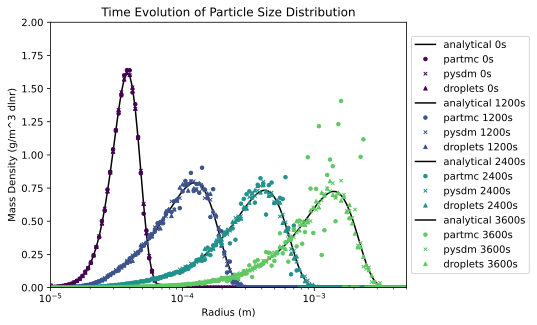

In [10]:
t_steps = np.divide(np.array(range(0, int(settings.T_MAX_SEC+1), 1200)),settings.PLOT_TIME_STEP).astype(int)
radius_bins = np.array(models['partmc'].rad_grid.centers)

markers = {
    'partmc':'o', 
    'pysdm':'x',
    'droplets':'^',
}   
colors = plt.cm.viridis(np.linspace(0, 1, len(t_steps)+1))

for i,t in enumerate(t_steps):
    for key, model in models.items():
        if key == 'analytical':
            p = plt.plot(radius_bins, output[key][t], label=key + ' ' + str(t*settings.PLOT_TIME_STEP) + 's', color='black')
        else:
            p = plt.plot(radius_bins, output[key][t], markers[key],label=key + ' ' + str(t*settings.PLOT_TIME_STEP) + 's', ms=3.5,color=colors[i])


plt.xscale("log")
plt.xlabel("Radius (m)")
plt.ylabel(settings.BINNING_METHOD)
plt.xlim([settings.R_BINS_MIN,settings.R_BINS_MAX])
plt.ylim([0,2.0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Time Evolution of Particle Size Distribution")
plt.savefig('units.pdf', bbox_inches='tight')

show_plot()


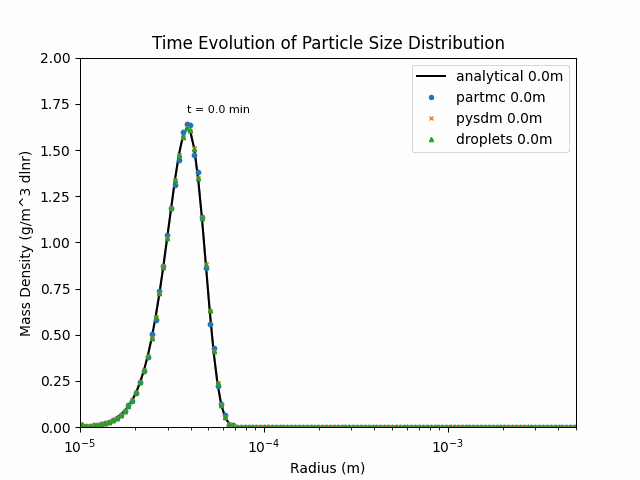

HTML(value="<a href='./tmpiv72nx47.gif' target='_blank'>./tmpiv72nx47.gif</a><br>")

In [11]:
plot_colors = {
    'analytical': 'black',
    'partmc': 'blue',
    'pysdm': 'red',
    'droplets': 'green',
}

def anim_func(frame):

    if frame > settings.T_MAX_SEC/settings.PLOT_TIME_STEP:
        frame = int(settings.T_MAX_SEC/settings.PLOT_TIME_STEP)

    t = list(range(0, int((frame+1)*settings.PLOT_TIME_STEP), 1200))

    for t_sec in t:
        step = int(t_sec/settings.PLOT_TIME_STEP)

        idx = np.argmax(output['analytical'][step])
        text_height = 1.05*max(output['analytical'][step])
        plt.text(radius_bins[idx], text_height, f't = {t_sec/60} min', fontsize=8)

        for key, model in models.items():
            if key == 'analytical':
                plt.plot(radius_bins, output[key][step], color='darkgrey')
            else:
                plt.plot(radius_bins, output[key][step], markers[key], ms=3,color='darkgrey')
    
    for key, model in models.items():
        if key == 'analytical':
            plt.plot(radius_bins, output[key][frame], label=key + ' ' + str(frame*settings.PLOT_TIME_STEP/60) + 'm', color='black')
        else:
            plt.plot(radius_bins, output[key][frame], markers[key],label=key + ' ' + str(frame*settings.PLOT_TIME_STEP/60) + 'm', ms=3)

    
    plt.xscale("log")
    plt.xlabel("Radius (m)")
    plt.ylabel(settings.BINNING_METHOD)
    plt.ylim([0,2])
    plt.xlim([settings.R_BINS_MIN,settings.R_BINS_MAX])
    plt.legend(loc='upper right')#, bbox_to_anchor=(1, 0.5))
    plt.title("Time Evolution of Particle Size Distribution")
    return plt.gcf()


frame_range = range(0,int(settings.T_MAX_SEC/settings.PLOT_TIME_STEP)+20,1)
show_anim(anim_func, frame_range)

In [12]:
# #TODO: add assert on match with analytical solution